In [70]:
# !uv pip install git+https://github.com/huggingface/transformers
# !uv pip install qwen-vl-utils
# !uv pip install openai
# !uv pip install setuptools
# !uv pip install flash-attn --no-build-isolation
# !uv pip install torch transformers accelerate bitsandbytes
# !pip install -U bitsandbytes transformers accelerate

# --- Installation of Fonts ---
# Устанавливаем специализированные шрифты для кириллицы
# !apt-get install -y fonts-ubuntu  # Ubuntu шрифты с отличной поддержкой кириллицы
# !apt-get install -y fonts-open-sans # Open Sans - хороший шрифт для кириллицы
# !apt-get install -y fonts-croscore # Включает Arimo, хороший шрифт для отображения кириллицы


# !pip install optimum onnxruntime onnx
# !pip install onnxruntime-gpu

In [71]:
# --- Imports ---
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
from IPython.display import Markdown, display
from openai import OpenAI
import os
import base64
from PIL import Image
from IPython.display import display
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from PIL import Image
from IPython.display import display
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import json
import re
import json
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from typing import List, Dict

# --- Utility Functions ---
def parse_json(json_output):
    """Parses JSON string, removes markdown fencing if present."""
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Get content after ```json
            json_output = json_output.split("```")[0]  # Get content before closing ```
            break  # Stop searching after finding ```json
    return json_output

def extract_json(response, start_marker="```json"):
    """Extracts a JSON array of objects from a string after a specified start marker."""
    json_start_index = response.find(start_marker)
    if json_start_index != -1:
        json_part = response[json_start_index + len(start_marker):]
        match = re.search(r'\[\s*\{.*?\}\s*(?:,\s*\{.*?\}\s*)*\]', json_part, re.DOTALL)
        if match:
            json_str = match.group(0)
            print("Extracted JSON string:", json_str)
            try:
                return json.loads(json_str)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                return None
        else:
            print(f"No valid JSON array found after the '{start_marker}' marker.")
            return None
    else:
        print(f"'{start_marker}' marker not found in the response.")
        return None

def encode_image(image_path):
    """Encodes an image file to a Base64 string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def plot_text_bounding_boxes(image_path, bounding_boxes, input_width, input_height):
    """Plots bounding boxes with text on an image using normalized coordinates."""
    # Load the image
    img = Image.open(image_path)
    width, height = img.size
    print(f"Image size: {img.size}")

    # Prepare to draw on the image
    draw = ImageDraw.Draw(img)

    # Handle JSON string input for bounding boxes
    if isinstance(bounding_boxes, str):
        bounding_boxes = parse_json(bounding_boxes)
        try:
            bounding_boxes = ast.literal_eval(bounding_boxes)
        except (SyntaxError, ValueError) as e:
            print(f"Oops! Couldn't understand the bounding box data: {e}")
            return

    # List of fonts to try for Cyrillic support
    font_paths = [
        "/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf",    # Ubuntu Regular
        "/usr/share/fonts/truetype/open-sans/OpenSans-Regular.ttf",  # Open Sans
        "/usr/share/fonts/truetype/croscore/Arimo-Regular.ttf",  # Arimo (like Arial)
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"    # Backup font
    ]

    # Find and load a suitable font
    font = None
    for path in font_paths:
        try:
            font = ImageFont.truetype(path, size=10)
            print(f"Using font: {path}")
            break
        except IOError:
            continue

    # Fallback to default font if no suitable font is found
    if font is None:
        font = ImageFont.load_default()
        print("Warning: Using default font. Russian text might not display correctly.")

    # Go through each bounding box
    for i, bbox_info in enumerate(bounding_boxes):
        color = 'green'
        bbox = bbox_info.get("bbox")
        text_content = bbox_info.get("text_content", "")

        # Skip if bounding box info is missing
        if not bbox:
            continue

        # Convert normalized coordinates [y1 x1 y2 x2] to absolute [x1 y1 x2 y2]
        abs_y1 = int(bbox[1] / input_height * height)
        abs_x1 = int(bbox[0] / input_width * width)
        abs_y2 = int(bbox[3] / input_height * height)
        abs_x2 = int(bbox[2] / input_width * width)

        # Ensure x1 <= x2 and y1 <= y2
        x1 = min(abs_x1, abs_x2)
        y1 = min(abs_y1, abs_y2)
        x2 = max(abs_x1, abs_x2)
        y2 = max(abs_y1, abs_y2)

        # Draw the rectangle
        draw.rectangle(((x1, y1), (x2, y2)), outline=color, width=1)

        # Add the text label if available
        if text_content:
            draw.text((x1, y2), text_content, fill=color, font=font)

    # Show the image with bounding boxes
    img.show()

def get_image_size(image_path):
    try:
        img = Image.open(image_path)
        width, height = img.size
        print(f"Image width: {width} pixels and height: {height} pixels.")
    except FileNotFoundError:
        print(f"Error: Image not found at '{image_path}'")
    return width, height

def load_model(checkpoint="Qwen/Qwen2.5-VL-3B-Instruct", clean_cache=False):
    """Load and cache the model and processor to avoid reloading on subsequent calls."""
    global _model_cache

    if clean_cache:
        _model_cache = {}

    if checkpoint in _model_cache:
        print(f"✅ Loaded from cache: {checkpoint}")
        return _model_cache[checkpoint]

    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    try:
        model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            checkpoint,
            do_sample=True,
            torch_dtype=torch.bfloat16,
            device_map=device
        )
        processor = AutoProcessor.from_pretrained(checkpoint)
        _model_cache[checkpoint] = (model, processor)
        print(f"🚀 Model and processor loaded and cached: {checkpoint}")
        return model, processor

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

def inference(image_path, prompt, processor, model, sys_prompt="You are a helpful OCR assistant for medical prescriptions.", max_new_tokens=2048, return_input=False, verbose=False):
    """Performs inference using a local vision-language model."""
    image = Image.open(image_path).convert("RGB").resize((600, 800), Image.LANCZOS)
    image_local_path = "file://" + image_path

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"image": image_local_path},
        ]}
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    if verbose:
        print("Text input to model:", text)

    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            use_cache=True
        )

    output_text = processor.batch_decode(output_ids, skip_special_tokens=True)
    return (output_text[0], inputs) if return_input else output_text[0]

    """Performs inference using a local vision-language model."""
    image = Image.open(image_path).resize((600, 800), Image.LANCZOS)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"image": image_local_path},
        ]}
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("Text input to model:", text)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False, use_cache=True)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return (output_text[0], inputs) if return_input else output_text[0]


def render_json_response(
    image_path: str,
    json_response: List[Dict],
    font_size: int = 8,
    font_name: str = "arial.ttf"
) -> None:
    """
    Render bounding boxes and text labels on a white canvas based on JSON response.
    
    Args:
        image_path: Path to the original image (used for dimensions)
        json_response: List of dictionaries containing 'text' and 'bbox' keys
        font_size: Font size for text labels (default: 8)
        font_name: Font file to use (default: "arial.ttf")
    """
    try:
        # Load original image dimensions
        original_img = Image.open(image_path)
        canvas = _create_white_canvas(original_img.size)
        draw = ImageDraw.Draw(canvas)
        font = _load_font(font_name, font_size)

        # Draw each annotation
        for annotation in json_response:
            _draw_annotation(draw, annotation, font, font_size)

        display(canvas)

    except FileNotFoundError:
        print(f"Error: Image not found at '{image_path}'")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

def _create_white_canvas(size: tuple) -> Image.Image:
    """Create a white canvas with given dimensions."""
    return Image.new("RGB", size, "white")

def _load_font(font_name: str, font_size: int) -> ImageFont.FreeTypeFont:
    """Load specified font or fall back to default."""
    try:
        return ImageFont.truetype(font_name, font_size)
    except (ImportError, IOError):
        print(f"Warning: Font '{font_name}' not found. Using default font.")
        return ImageFont.load_default()

def _draw_annotation(
    draw: ImageDraw.Draw,
    annotation: Dict,
    font: ImageFont.FreeTypeFont,
    font_size: int
) -> None:
    """Draw a single annotation (bounding box + text) on the canvas."""
    text = annotation['text']
    x1, y1, x2, y2 = annotation['bbox']
    
    # Draw bounding box
    draw.rectangle([(x1, y1), (x2, y2)], outline='red', width=2)
    
    # Draw text label
    text_position = (x1, y1 - font_size - 2)
    draw.text(text_position, text, fill='blue', font=font)

Image width: 489 pixels and height: 479 pixels.


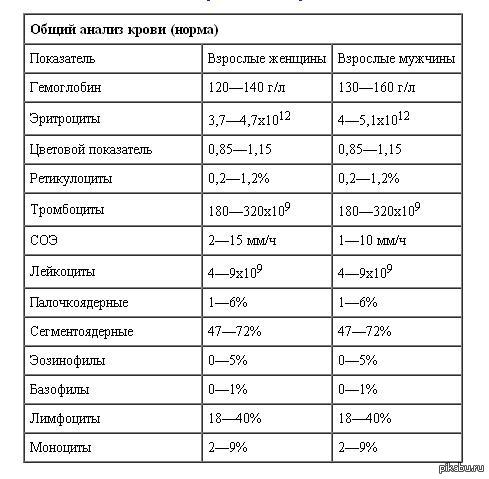

In [72]:
IMAGE_PATH = "/home/ubuntu/OCR/data/det/test/4.jpg"

PROMT = """"This image contains a medical prescription with text primarily in Russian. Analyze the image and extract all text elements.image  dimensions width: 489 pixels and height: 479 pixels. For each detected text element, identify its textual content and bounding box. Return the result as a JSON array of objects. Each object should have the following fields:
    - 'text': A string with the recognized text (preserving the Russian language).
    - 'bbox': An array of four integers representing the absolute coordinates of the bounding box in the format [x1, y1, x2, y2], where (x1, y1) are the coordinates of the top-left corner, and (x2, y2) are the coordinates of the bottom-right corner.

Example output format:
[
    {
        \"text\": \"Пример текста на русском\",
        \"bbox\": [100, 50, 300, 80]
    },
    {
        \"text\": \"Еще слово\",
        \"bbox\": [150, 120, 250, 140]
    }
]"""

MODEL = "Qwen/Qwen2.5-VL-3B-Instruct"

width, height = get_image_size(IMAGE_PATH)

# --- Display the image ---
image = Image.open(IMAGE_PATH)
# display(image.resize((600, 600)))
display(image)

In [73]:
# Define global cache
_model_cache = {}

In [74]:
model, processor = load_model()

# Compile the model for faster inference
model = torch.compile(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🚀 Model and processor loaded and cached: Qwen/Qwen2.5-VL-3B-Instruct


In [75]:
# --- Perform inference using the local model if loaded successfully ---
if model and processor:
    response = inference(IMAGE_PATH, PROMT, processor, model)
    print(response)
else:
    print("Model or processor not loaded, skipping local inference.")

/home/ubuntu/llm_venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


system
You are a helpful OCR assistant for medical prescriptions.
user
"This image contains a medical prescription with text primarily in Russian. Analyze the image and extract all text elements.image  dimensions width: 489 pixels and height: 479 pixels. For each detected text element, identify its textual content and bounding box. Return the result as a JSON array of objects. Each object should have the following fields:
    - 'text': A string with the recognized text (preserving the Russian language).
    - 'bbox': An array of four integers representing the absolute coordinates of the bounding box in the format [x1, y1, x2, y2], where (x1, y1) are the coordinates of the top-left corner, and (x2, y2) are the coordinates of the bottom-right corner.

Example output format:
[
    {
        "text": "Пример текста на русском",
        "bbox": [100, 50, 300, 80]
    },
    {
        "text": "Еще слово",
        "bbox": [150, 120, 250, 140]
    }
]
assistant
```json
[
    {
        "text": "

In [76]:

# def load_model(checkpoint="Qwen/Qwen2.5-VL-3B-Instruct"):
#     # --- Load the processor and model ---
#     checkpoint = "Qwen/Qwen2.5-VL-3B-Instruct"
#     device = "cuda:0" if torch.cuda.is_available() else "cpu"

#     try:
#         model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#             checkpoint,
#             do_sample=True,
#             torch_dtype=torch.bfloat16,
#             device_map=device
#         )
#         processor = AutoProcessor.from_pretrained(checkpoint)
#         print("Model and processor loaded successfully!")
#     except Exception as e:
#         print(f"Error loading model: {e}")
#         model = None
#         processor = None
#     return model, processor

# model, processor = load_model(checkpoint=MODEL)

# # --- Perform inference using the local model if loaded successfully ---
# if model and processor:
#     response = inference(IMAGE_PATH, PROMT, processor, model)
#     print(response)
# else:
#     print("Model or processor not loaded, skipping local inference.")

In [77]:
# Extract and print the JSON content
json_response = extract_json(response)
print(json_response)

Extracted JSON string: [
    {
        "text": "Общий анализ крови (норма)",
        "bbox": [16, 28, 220, 40]
    },
    {
        "text": "Показатель",
        "bbox": [24, 50, 100, 60]
    },
    {
        "text": "Взрослые женщины",
        "bbox": [102, 50, 200, 60]
    },
    {
        "text": "Взрослые мужчины",
        "bbox": [202, 50, 300, 60]
    },
    {
        "text": "Гемоглобин",
        "bbox": [24, 70, 100, 80]
    },
    {
        "text": "120—140 г/л",
        "bbox": [102, 70, 200, 80]
    },
    {
        "text": "130—160 г/л",
        "bbox": [202, 70, 300, 80]
    },
    {
        "text": "Эритроциты",
        "bbox": [24, 90, 100, 100]
    },
    {
        "text": "3,7—4,7х1012",
        "bbox": [102, 90, 200, 100]
    },
    {
        "text": "4—5,1х1012",
        "bbox": [202, 90, 300, 100]
    },
    {
        "text": "Цветовой показатель",
        "bbox": [24, 110, 100, 120]
    },
    {
        "text": "0,85—1,15",
        "bbox": [102, 110, 200, 120]
    

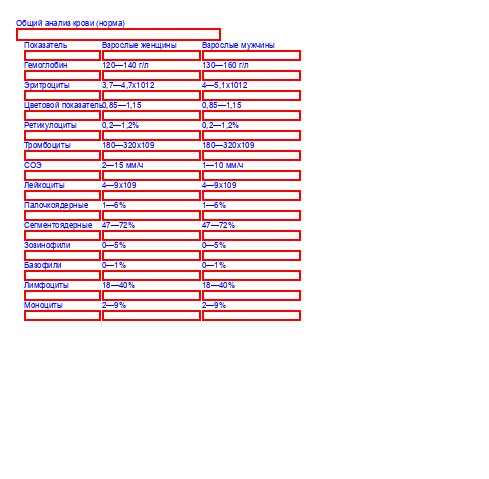

In [78]:
render_json_response(IMAGE_PATH, json_response, font_size=8)

In [79]:
torch.cuda.empty_cache()